<a href="https://colab.research.google.com/github/YaoYinYing/GREMLIN_PyTorch_Replica/blob/main/GREMLIN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# -*- coding: utf-8 -*-
"""
GREMLIN (PyTorch version, with a custom "opt_adam" replicating the original)
Yinying Yao rewrite this PyTorch version with the help of ChatGPT o1
original: https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb

--------------------------------------------------------------------------------
This code replicates:
1) The original GREMLIN model in PyTorch.
2) A custom Adam optimizer that follows the original TensorFlow "opt_adam"
   logic: it uses a single scalar for vt (the sum of squares of the gradient),
   and optionally disables bias-correction if b_fix=True.

The final 'mrf' dict has the same format as the original:
  mrf["v"]      -> (ncol, states) array of one-body parameters
  mrf["w"]      -> (#pairs, states, states) array of two-body parameters
  mrf["v_idx"]  -> index mapping for V
  mrf["w_idx"]  -> index mapping for W (each row is [col_i, col_j])

--------------------------------------------------------------------------------
"THE BEERWARE LICENSE" (Revision 42):
 <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote the original code.
 As long as you retain this notice, you can do whatever you want with this stuff.
 If we meet someday, and you think this stuff is worth it, you can buy us a beer
 in return.
 --Sergey Ovchinnikov and Peter Koo
--------------------------------------------------------------------------------
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim.optimizer import Optimizer
from scipy.spatial.distance import pdist, squareform
from scipy import stats

###################################
# Alphabet and Basic Setup
###################################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {a: i for i, a in enumerate(alphabet)}

def aa2num(aa):
    if aa in a2n:
        return a2n[aa]
    else:
        return a2n['-']

###################################
# FASTA Parse
###################################
def parse_fasta(filename, limit=-1):
    headers = []
    seqs = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if limit > 0 and len(headers) == limit:
                    break
                headers.append(line[1:])
                seqs.append([])
            else:
                seqs[-1].append(line)
    seqs = [''.join(s) for s in seqs]
    return np.array(headers), np.array(seqs)

###################################
# MSA Prep
###################################
def filt_gaps(msa, gap_cut=0.5):
    """Remove columns with more than gap_cut fraction of gaps."""
    gap_mask = (msa == states - 1).astype(np.float32)
    frac_gap = np.sum(gap_mask, axis=0) / msa.shape[0]
    keep_cols = np.where(frac_gap < gap_cut)[0]
    return msa[:, keep_cols], keep_cols

def get_eff(msa, eff_cut=0.8):
    """Compute sequence weights based on pairwise identity >= eff_cut."""
    pid = 1.0 - squareform(pdist(msa, 'hamming'))
    w = (pid >= eff_cut).astype(np.float32)
    return 1.0 / np.sum(w, axis=-1)

def mk_msa(seqs):
    """Make MSA dict from raw sequence strings."""
    msa_ori = []
    for s in seqs:
        msa_ori.append([aa2num(a) for a in s])
    msa_ori = np.array(msa_ori, dtype=np.int32)

    # remove gappy columns
    msa, v_idx = filt_gaps(msa_ori, 0.5)

    # weights
    weights = get_eff(msa, 0.8)
    nrow, ncol = msa.shape
    w_idx = v_idx[np.stack(np.triu_indices(ncol, 1), axis=-1)]

    return {
        "msa_ori": msa_ori,
        "msa": msa,
        "weights": weights,
        "neff": np.sum(weights),
        "v_idx": v_idx,
        "w_idx": w_idx,
        "nrow": nrow,
        "ncol": ncol,
        "ncol_ori": msa_ori.shape[1],
    }

###################################
# Custom Adam (replicating TF code)
###################################
class CustomAdamOpt(Optimizer):
    """
    Replicates the original "opt_adam" in TF:
      - single-scalar vt for sum(g^2)
      - mt same shape as param
      - optional bias-correction if b_fix=True
    """

    def __init__(self, params, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
        defaults = dict(lr=lr, b1=b1, b2=b2, b_fix=b_fix)
        super().__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            b1 = group['b1']
            b2 = group['b2']
            b_fix = group['b_fix']

            # We'll store 't' in the state of the first param in this group
            # (mirroring the original code's single variable per param group).
            state_0 = self.state[group['params'][0]]
            if 't' not in state_0:
                state_0['t'] = 0
            state_0['t'] += 1
            t = state_0['t']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                st = self.state[p]

                # ----------- FIX: safe initialization -----------
                if 'mt' not in st:
                    st['mt'] = torch.zeros_like(p.data)
                if 'vt' not in st:
                    st['vt'] = torch.zeros(1, device=p.device)
                # ------------------------------------------------

                mt = st['mt']
                vt = st['vt']

                # mt <- b1*mt + (1-b1)*grad
                mt.mul_(b1).add_(grad, alpha=(1 - b1))

                # vt <- b2*vt + (1-b2)*sum(grad^2)
                grad_sq_sum = torch.sum(grad * grad)
                vt.mul_(b2).add_(grad_sq_sum, alpha=(1 - b2))

                # step_size = lr / sqrt(vt + 1e-8)
                denom = vt.sqrt().add_(1e-8)
                step_size = lr / denom

                # optional bias correction
                if b_fix:
                    step_size = step_size * ((1 - b2**t)**0.5 / (1 - b1**t))

                # param <- param - step_size*mt
                p.data.add_(mt, alpha=(-step_size.item()))

        return loss


###################################
# GREMLIN Model
###################################
class GremlinTorch(nn.Module):
    def __init__(self, ncol, neff, reg_f=0.01):
        super().__init__()
        self.ncol = ncol
        self.neff = neff
        self.reg_f = reg_f

        # V param
        self.V = nn.Parameter(torch.zeros(ncol, states))
        # W param
        self.W = nn.Parameter(torch.zeros(ncol, states, ncol, states))

    def symmetrize_w(self, w):
        w_sym = 0.5 * (w + w.permute(2,3,0,1))
        eye = torch.eye(self.ncol, device=w.device, dtype=torch.bool).view(self.ncol,1,self.ncol,1)
        return w_sym.masked_fill_(eye, 0.0)

    def forward(self, MSA_oh, MSA_weights):
        W_sym = self.symmetrize_w(self.W)
        # tensordot => einsum
        # VW[b, j, l] = sum_{i,k} MSA_oh[b,i,k] * W_sym[i,k,j,l]  + V[j,l]
        VW = torch.einsum("bik,ikjl->bjl", MSA_oh, W_sym) + self.V.unsqueeze(0)

        # H = sum_{i,k} MSA_oh[b,i,k]*VW[b,i,k]
        #   but i,k in VW => i->j dimension in VW is different, so we do a direct multiply:
        H = (MSA_oh * VW).sum(dim=(1,2))
        # Z = sum_i(logsumexp(VW[b,i,:]))
        Z = torch.logsumexp(VW, dim=2).sum(dim=1)
        PLL = H - Z
        negPLL = - (PLL * MSA_weights).sum() / (MSA_weights.sum() + 1e-8)

        # L2 reg
        l2_V = self.reg_f * (self.V ** 2).sum()
        l2_W_factor = self.reg_f * 0.5 * (self.ncol - 1) * (states - 1)
        l2_W = l2_W_factor * (self.W ** 2).sum()
        reg = (l2_V + l2_W) / self.neff

        return negPLL + reg

###################################
# Main GREMLIN routine
###################################
def GREMLIN(msa,
            opt_type="adam",
            opt_iter=100,
            lr=1.0,
            b1=0.9,
            b2=0.999,
            b_fix=False,
            batch_size=None):
    """
    If you want to replicate the original code's 'opt_adam' exactly:
      opt_type="adam", b_fix=False, lr=1.0, b1=0.9, b2=0.999, opt_iter=100
      (and batch_size=None for full-batch)
    """
    model = GremlinTorch(msa["ncol"], msa["neff"], reg_f=0.01)

    # Build MSA one-hot tensor
    oh = np.zeros((msa["nrow"], msa["ncol"], states), dtype=np.float32)
    for i in range(msa["nrow"]):
        for j in range(msa["ncol"]):
            oh[i, j, msa["msa"][i,j]] = 1.0
    MSA_oh_torch = torch.from_numpy(oh)
    MSA_weights_torch = torch.from_numpy(msa["weights"]).float()

    # Initialize V
    pseudo_count = 0.01 * np.log(msa["neff"] + 1e-8)
    wc = (oh.transpose(1,2,0) * msa["weights"]).sum(axis=-1)
    V_ini = np.log(wc + pseudo_count)
    V_ini = V_ini - V_ini.mean(axis=1, keepdims=True)
    with torch.no_grad():
        model.V.copy_(torch.from_numpy(V_ini))

    # Build optimizer
    if opt_type.lower() == "adam":
        optimizer = CustomAdamOpt(
            model.parameters(),
            lr=lr,
            b1=b1,
            b2=b2,
            b_fix=b_fix
        )
    elif opt_type.lower() == "lbfgs":
        optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, max_iter=opt_iter)
    else:
        raise ValueError("Unknown opt_type: %s" % opt_type)

    def full_loss():
        with torch.no_grad():
            val = model(MSA_oh_torch, MSA_weights_torch)
        return float(val.item() * msa["neff"])

    print("starting", round(full_loss(), 2))

    if opt_type.lower() == "lbfgs":
        def closure():
            optimizer.zero_grad()
            l = model(MSA_oh_torch, MSA_weights_torch)
            l.backward()
            return l
        optimizer.step(closure)
        print("final", round(full_loss(), 2))

    else:
        # Adam or custom Adam
        for i in range(opt_iter):
            if batch_size is None:
                # full-batch
                optimizer.zero_grad()
                l = model(MSA_oh_torch, MSA_weights_torch)
                l.backward()
                optimizer.step()
            else:
                # mini-batch
                idx = np.random.randint(0, msa["nrow"], size=batch_size)
                oh_batch = MSA_oh_torch[idx]
                wt_batch = MSA_weights_torch[idx]
                optimizer.zero_grad()
                l = model(oh_batch, wt_batch)
                l.backward()
                optimizer.step()

            # print progress ~10 times
            if (i + 1) % max(1, opt_iter//10) == 0:
                print("iter", i+1, round(full_loss(), 2))

    # Extract final V & W
    V_final = model.V.detach().cpu().numpy()
    with torch.no_grad():
        W_sym = model.symmetrize_w(model.W).detach().cpu().numpy()

    tri_i, tri_j = np.triu_indices(msa["ncol"], 1)
    W_triu = W_sym[tri_i, :, tri_j, :]

    return {
        "v": V_final,
        "w": W_triu,
        "v_idx": msa["v_idx"],
        "w_idx": msa["w_idx"],
    }

###################################
# Extra contact map utilities
###################################
def normalize(x):
    x = stats.boxcox(x - np.amin(x) + 1.0)[0]
    mean_x = np.mean(x)
    std_x = np.std(x)
    return (x - mean_x)/(std_x + 1e-8)

def get_mtx(mrf):
    raw = np.sqrt(np.sum(mrf["w"][:, :-1, :-1] ** 2, axis=(1,2)))
    raw_sq = squareform(raw)
    ap_sq = (
        np.sum(raw_sq, 0, keepdims=True)
        * np.sum(raw_sq, 1, keepdims=True)
        / np.sum(raw_sq)
    )
    apc = squareform(raw_sq - ap_sq, checks=False)
    return {
        "i": mrf["w_idx"][:, 0],
        "j": mrf["w_idx"][:, 1],
        "raw": raw,
        "apc": apc,
        "zscore": normalize(apc),
    }

def plot_mtx(mtx, key="zscore", vmin=1, vmax=3):
    """
    Quick convenience plot, ensuring it's a separate figure.
    """
    import matplotlib.pylab as plt
    plt.figure()
    plt.imshow(squareform(mtx[key]),
               cmap='Blues',
               interpolation='none',
               vmin=vmin, vmax=vmax)
    plt.grid(False)
    plt.show()


In [11]:
# download example fasta MSA
!wget --no-check-certificate -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [12]:
headers, seqs = parse_fasta("4FAZA.fas")

In [13]:
msa = mk_msa(seqs)

In [14]:
mrf = GREMLIN(
        msa,
        opt_type="adam",
        opt_iter=100,
        lr=1.0,
        b1=0.9,
        b2=0.999,
        b_fix=False,   # disable bias-correction to match original
        batch_size=None
    )

starting 50463.15
iter 10 29666.4
iter 20 27719.82
iter 30 27002.54
iter 40 26668.77
iter 50 26568.35
iter 60 26531.0
iter 70 26518.21
iter 80 26513.29
iter 90 26511.21
iter 100 26510.29


In [15]:
mtx = get_mtx(mrf)

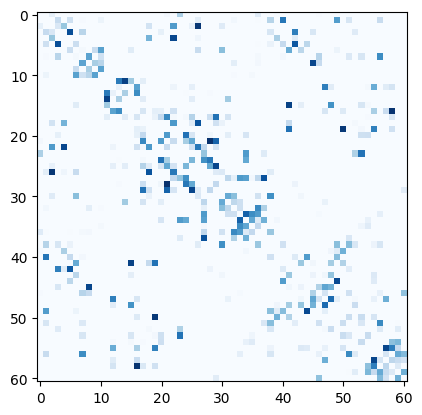

In [16]:
plot_mtx(mtx) # pytorch version

In [17]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the i,j index starts at 0 (zero)
# - the "first" position = 0
# - often in biology first position of a sequence is 1
#   for this index use i_aa and j_aa!

# adding amino acid to index
mtx["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx["i"]])
mtx["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx["j"]])

# load mtx into pandas dataframe
pd_mtx = pd.DataFrame(mtx,columns=["i","j","apc","zscore","i_aa","j_aa"])

# get contacts with sequence seperation > 5
# sort by zscore, show top 10
top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
top.head(10)

,i,j,apc,zscore,i_aa,j_aa
1056,21,28,0.875397,2.976786,K_22,E_29
881,16,58,0.848746,2.961988,R_17,A_59
142,2,26,0.817153,2.942967,A_3,M_27
999,19,50,0.785871,2.922388,I_20,G_51
820,15,41,0.703886,2.858746,K_16,I_42
488,8,45,0.665057,2.822762,E_9,P_46
251,4,22,0.659830,2.817586,I_5,V_23
1278,27,37,0.597962,2.749542,M_28,V_38
934,18,26,0.583669,2.731856,V_19,M_27
326,5,42,0.554494,2.693147,Y_6,H_43


## Explore the MRF

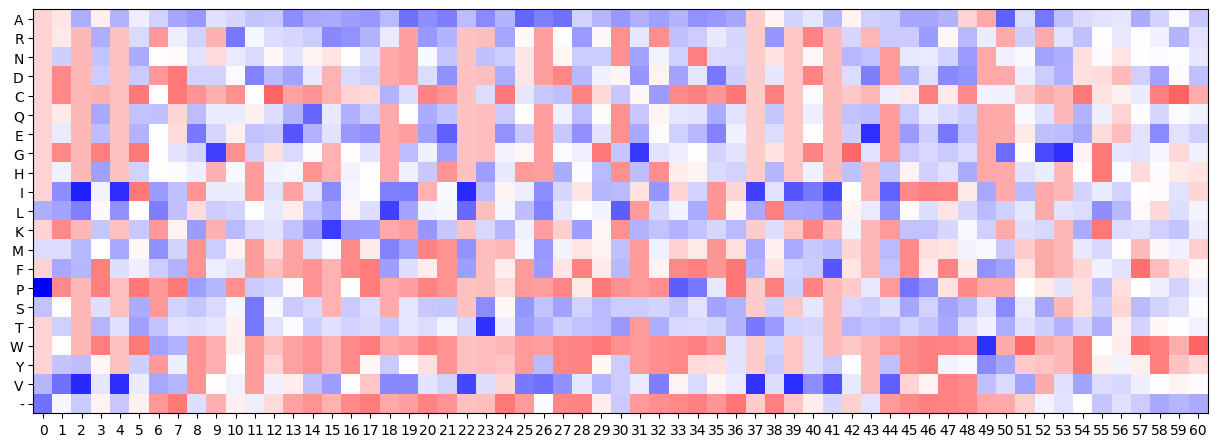

In [18]:
import matplotlib.pylab as plt

def plot_v(mrf):
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: mrf["v_idx"][x]))
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))

plot_v(mrf)

<ipython-input-19-1b1908eb6917>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])


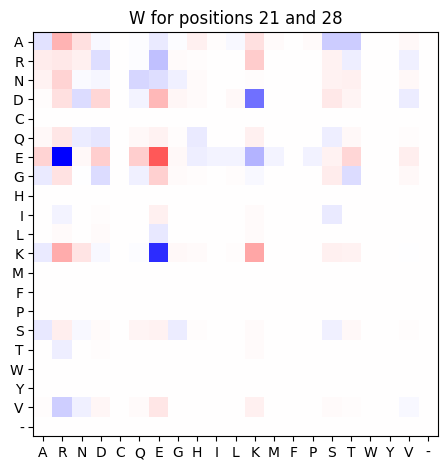

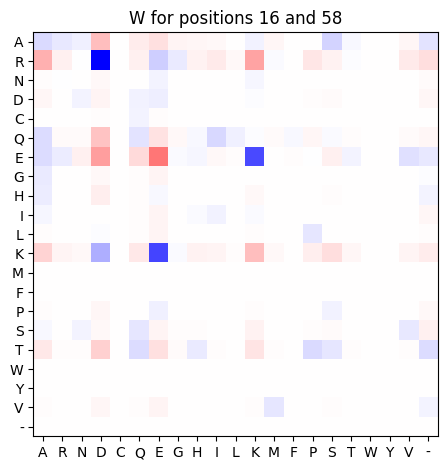

In [19]:
def plot_w(mrf,i,j):

  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])
  w = mrf["w"][n]

  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)

  ax = plt.gca()
  al_a = list(alphabet)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j)

## validating output
(comparing to known output from GREMLIN_cpp version)

In [20]:
!wget -q -nc --no-check-certificate http://files.ipd.uw.edu/krypton/4FAZA.out

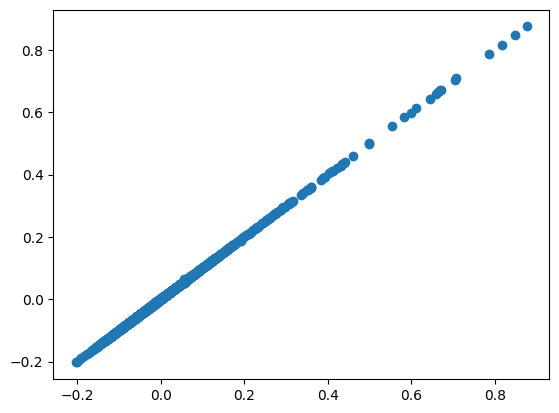

In [21]:
pd_test = pd.read_table("4FAZA.out",sep=" ")
plt.scatter(pd_test["apc"],mtx["apc"])
plt.show()

## Useful input features for NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [22]:
w_out = np.zeros((msa["ncol_ori"], msa["ncol_ori"], states * states + 1))
v_out = np.zeros((msa["ncol_ori"], states))

mrf_ = np.reshape(mrf["w"],(-1, states * states))
mtx_ = np.expand_dims(mtx["apc"],-1)

w_out[(mtx["i"],mtx["j"])] = np.concatenate((mrf_, mtx_),-1)
w_out += np.transpose(w_out,(1,0,2))
v_out[mrf["v_idx"]] = mrf["v"]

print("w_out",w_out.shape)
print("v_out",v_out.shape)

w_out (62, 62, 442)
v_out (62, 21)
